# SageMaker Endpoint에 사전 훈련된 모델을 호스팅 후 Object Deteciton 수행하기 (MXNet-GluonCV)
---

Amazon SageMaker에서 추론(inference)을 수행하려면 반드시 SageMaker에서 먼저 훈련을 수행해야 하나요? 그렇지 않습니다.<br>
만약 여러분이 SageMaker에서 추론만 수행하고 싶다면, 여러분의 온프레미스(on-premise)에서 훈련한 모델이나 공개 모델 저장소(model zoo)에 저장되어 있는 사전 훈련된(pre-trained) 모델들을 도커(Docker) 이미지 빌드 없이 그대로 SageMaker Endpoint에 배포할 수 있습니다. 
여러분이 수행할 작업은 오로지 추론용 엔트리포인트(entrypoint)만 작성하는 것입니다.

우선, MXNet용 엔트리포인트 인터페이스에 대해 간단히 살펴 보도록 하겠습니다. 

- `model_fn(model_dir)`: 딥러닝 네트워크 아키텍처를 정의하고 S3의 model_dir에 저장된 모델 아티팩트를 로드합니다.
- `input_fn(request_body, content_type)`: 입력 데이터를 전처리합니다. (예: request_body로 전송된 bytearray 배열을 PIL.Image로 변환 수 cropping, resizing, normalization등의 전처리 수행). content_type은 입력 데이터 종류에 따라 다양하게 처리 가능합니다. (예: application/x-npy, application/json, application/csv 등)
- `predict_fn(input_object, model)`: input_fn을 통해 들어온 데이터에 대해 추론을 수행합니다. 
- `output_fn(prediction, content_type)`: predict_fn에서 받은 추론 결과를 추가 변환을 거쳐 프론트 엔드로 전송합니다. 

이 노트북에서는 MXNet의 GluonCV API를 사용하여 사전 훈련된 `yolo3_darknet53_coco` 모델을 SageMaker 엔드포인트에 배포 후, Object Detection을 수행합니다. GluonCV는 컴퓨터 비전 분야의 최신(SOTA; State of the art) 딥러닝 사전 훈련된 모델들을 model zoo로 제공할 뿐 아니라, 컴퓨터 비전에서 많이 쓰이는 기능들을 명확하고 간결한 API로 제공합니다. 


## Pre-requisites

- 기본 용법: [GluonCV](https://gluon-cv.mxnet.io/tutorials/index.html), [MXNet](https://mxnet.apache.org/)
- AWS 서비스: [AWS S3](https://docs.aws.amazon.com/s3/index.html), [Amazon SageMaker](https://aws.amazon.com/sagemaker/)

In [1]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.mxnet import MXNetModel

<br>


# 1. Deployment
----


## Model Packaging

Fine-tuning 없이 곧바로 사전 훈련된 모델을 사용할 것이므로 `model.tar.gz`는 0바이트의 빈 파일로 구성합니다.
만약 온프레미스에서 fine-tuning을 수행한 모델을 사용하고 싶다면, 모델 파라메터들을 `model.tar.gz`로 압축하세요.

In [2]:
%%bash
rm -rf my_model
mkdir my_model
tar -czf model.tar.gz my_model

#### [주의] 아래 코드 셀을 그대로 실행하지 마시고 bucket 이름을 반드시 수정해 주세요.
```python
bucket = '[YOUR-S3-BUCKET]' # as-is
bucket = 'sagemaker-hol-daekeun' # to-be
```

In [3]:
role = get_execution_role()
bucket = '[YOUR-S3-BUCKET]' # bucket 이름을 반드시 수정해 주세요.
#bucket = 'sagemaker-hol-daekeun'
#bucket = sagemaker.Session().default_bucket() # SageMaker에서 자동으로 생성되는 bucket

In [4]:
%%bash -s "$role" "$bucket"
ROLE=$1
BUCKET=$2

aws s3 cp model.tar.gz s3://$BUCKET/model.tar.gz

upload: ./model.tar.gz to s3://sagemaker-us-east-1-143656149352/model.tar.gz


## Model Deployment 
SageMaker SDK로 모델 배포를 수행하는 방법은 매우 간단합니다. PyTorch으로 배포 시에는 엔트리포인트 코드를 PyTorch용으로 변경 후, `MXNetModel` 대신 `PyTorchModel` 클래스로 인스턴스를 생성하면 됩니다.

#### CPU/GPU

본 노트북에서는 범용 컴퓨팅 CPU 인스턴스로 추론을 수행합니다. 왜일까요?<br>
머신러닝 워크로드의 전체 비용을 고려할 때 추론이 전체 비용의 90%를 차지하는 경우가 많습니다. **<font color='red'>즉, 추론 시 GPU를 그대로 사용하게 되면 매우 많은 비용이 발생하게 됩니다.</font>**<br>
따라서, 대량의 데이터를 배치 변환(batch transform)해야 하거나 응답 속도가 매우 빨라야 하는(예: 10ms) 어플리케이션이 아닌 이상 CPU 인스턴스로 먼저 추론을 수행하세요.

#### Elastic Inference
응답 속도가 매우 빨라야 하는 어플리케이션의 경우 GPU 인스턴스의 사용을 고려하게 될 수 있습니다.
하지만, GPU 인스턴스 유형이 실시간 추론에 사용되는 경우 일반적으로 훈련과 달리 실시간 훈련에는 대량의 데이터를 모델에 지속적으로 입력하지 않으므로 일반적으로 완전히 활용되지 않습니다.<br>
Elastic Inference는 추론에 적합한 GPU 가속을 제공하므로, 범용 컴퓨팅 CPU 인스턴스와 Elastic Inference를 같이 활용하면 GPU 인스턴스를 사용하는 것보다 훨씬 저렴한 비용으로 Endpoint를 호스팅할 수 있습니다. 
자세한 내용은 아래 링크를 참조해 주세요.<br>
https://docs.aws.amazon.com/ko_kr/sagemaker/latest/dg/ei.html

참고로, 아래 코드 셀은 약 7-9분이 소요됩니다.

In [5]:
%%time
model = MXNetModel(model_data='s3://{}/model.tar.gz'.format(bucket), 
                   role=role,
                   entry_point='inference_mxnet.py', 
                   source_dir='src',
                   framework_version='1.4.1',
                   py_version='py3')

predictor = model.deploy(instance_type='ml.c4.xlarge', initial_instance_count=1)

---------------!CPU times: user 416 ms, sys: 24.2 ms, total: 440 ms
Wall time: 7min 32s


<br>


# 2. Real-time Inference
----

Endpoint 생성이 완료되었으면, 테스트 영상에 대한 object detection을 수행해 보겠습니다.


### Label Map 딕셔너리 변환
Class 레이블에 대응하는 클래스명을 가져옵니다.

In [7]:
def get_label_map(label_file):
    label_map = {}
    labels = open(label_file, 'r')
    
    for line in labels:
        line = line.rstrip("\n")
        ids = line.split(',')
        label_map[int(ids[0])] = ids[2] 
        
    return label_map

label_map = get_label_map('files/coco_labels.txt')
label_list = list(label_map.values())
print(label_map)

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'micro

테스트 이미지로 COCO dataset(http://cocodataset.org/#download) 의 2017 Val images를 6장 준비했습니다. 핸즈온을 잘 진행하셨다면, 주어진 6장의 영상 파일들 외에 여러분의 영상 파일들을 업로드하여 자유롭게 테스트해 보세요.<br>

참고로, Object Detection 출력 결과인 bounding box의 기본 임계치(threshold)는 0.5입니다.

### Get Inference Result

In [8]:
def get_inference(img_path):
    with open(img_path, 'rb') as fp:
        bimage = fp.read()
        
    input_json = {
        'short': 416, # YOLO's recommended image size
        'image': b64encode(bimage).decode('utf-8') 
    }
    
    outputs = predictor.predict(input_json)
    
    shape = outputs['shape']
    cids = mx.nd.array(outputs['cid'])
    scores = mx.nd.array(outputs['score'])
    bboxes = mx.nd.array(outputs['bbox'])    
    img_resized = mx.image.imresize(mx.image.imdecode(bimage), shape[3], shape[2])
    #request_body = json.dumps(input_json) # for testing on local    
    
    return img_resized, cids, scores, bboxes

In [10]:
!pip install gluoncv

    100% |████████████████████████████████| 757kB 24.4MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 31.6MB/s ta 0:00:01
You are using pip version 10.0.1, however version 20.1b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [11]:
import os
from base64 import b64encode, b64decode
import json
import mxnet as mx
from gluoncv import utils
from io import BytesIO
from PIL import Image

path = "./images/test"
img_list = os.listdir(path)
img_path_list = [os.path.join(path, img) for img in img_list]

test_idx = 3
img_path = img_path_list[test_idx]
img_resized, cids, scores, bboxes = get_inference(img_path)

### GluonCV API로 Bounding box plotting
GluonCV의 `plot_bbox` 메소드로 Object Detection 결과를 쉽게 plotting할 수 있습니다. 

In [12]:
%matplotlib inline

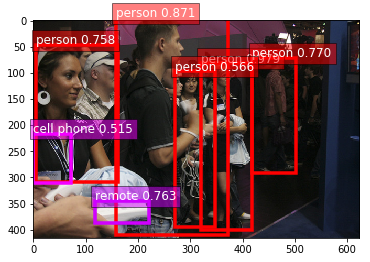

In [16]:
test_idx = 1
img_path = img_path_list[test_idx]
img_resized, cids, scores, bboxes = get_inference(img_path)
ax = utils.viz.plot_bbox(img_resized, bboxes, scores, cids, class_names=label_list)

### 직접 구현한 함수로 Bounding Box 그리기
물론, high-level API에 의존하지 않고 직접 bounding box를 그릴 수 있습니다. 아래 코드를 참조해 주세요.

In [17]:
def my_plot_bbox(img_resized, bboxes, scores, cids, class_names, threshold=0.5):

    import numpy as np
    import random
    import matplotlib.patches as patches
    import matplotlib.pyplot as plt

    scores = scores.asnumpy()
    bboxes = bboxes.asnumpy()
    cids = cids.asnumpy()

    # Get only results that are above the threshold. Default threshold is 0.5. 
    scores = scores[scores > threshold]
    num_detections = len(scores)
    bboxes = bboxes[:num_detections, :]
    cids = cids[:num_detections].astype('int').squeeze()

    # Get bounding-box colors
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]
    random.seed(42)
    random.shuffle(colors)

    img_np = img_resized.asnumpy()
    plt.figure()

    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.imshow(img_np)

    if cids is not None:
        # Get unique class labels 
        unique_labels = set(list(cids.astype('int').squeeze()))
        unique_labels = np.array(list(unique_labels))
        n_cls_preds = len(unique_labels)
        bbox_colors = colors[:n_cls_preds]

        for b, cls_pred, cls_conf in zip(bboxes, cids, scores):
            x1, y1, x2, y2 = b[0], b[1], b[2], b[3]
            predicted_class = label_list[int(cls_pred)]
            label = '{} {:.2f}'.format(predicted_class, cls_conf)
            
            # Get box height and width
            box_h = y2 - y1
            box_w = x2 - x1

            # Add a box with the color for this class
            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=3, edgecolor=color, facecolor='none')
            ax.add_patch(bbox)

            plt.text(x1, y1, s=label, color='white', verticalalignment='top',
                    bbox={'color': color, 'pad': 0})

<Figure size 432x288 with 0 Axes>

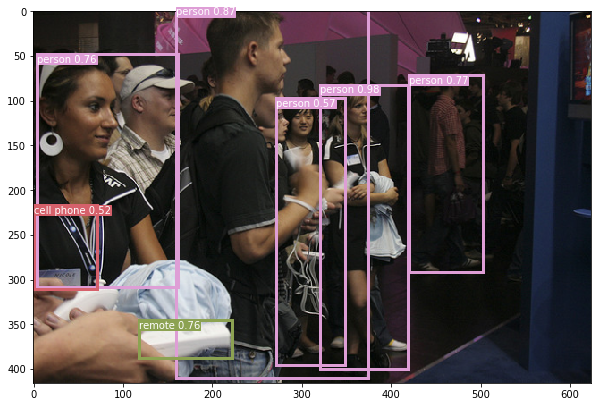

In [18]:
my_plot_bbox(img_resized, bboxes, scores, cids, class_names=label_list)

## (Optional) Clean up

SageMaker Endpoint로 인한 과금을 막기 위해, 본 핸즈온이 끝나면 반드시 Endpoint를 삭제해 주시기 바랍니다.

In [19]:
# predictor.delete_endpoint()